# Introduction to text embeddings on S&P 500 news

## 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [ ]:
#pip install lxml pandas yfinance 
#pip install -U sentence-transformers

In [39]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500

In [40]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [41]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [42]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library

df_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
ticker_list = df_tickers['Symbol'].tolist()
display(df_tickers.head())


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [43]:
news_dict = {}
for ticker in ticker_list:
 # print(ticker)
  try:
      stock = yf.Ticker(ticker)
      news = stock.news
      if news:
          news_dict[ticker] = news[0]  # solo 1 noticia por empresa
  except Exception:
      continue


Exception ignored from cffi callback <function buffer_callback at 0x3008cf280>:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Fintech/lib/python3.9/site-packages/curl_cffi/curl.py", line 68, in buffer_callback
    @ffi.def_extern()
KeyboardInterrupt: 


In [ ]:
df_news = pd.DataFrame([
    {
        'TICKER': ticker,
        'TITLE': item.get('content', {}).get('title', ''),
        'SUMMARY': item.get('content', {}).get('summary', ''),
        'PUBLICATION_DATE': item.get('content', {}).get('pubDate', ''),
        'URL': item.get('content', {}).get('canonicalUrl', {}).get('url', '')
    }
    for ticker, item in news_dict.items()
])
display(df_news.head())


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...
1,AOS,Here's Why A.O. Smith (AOS) is a Strong Value ...,"Wondering how to pick strong, market-beating s...",2025-07-28T13:40:03Z,https://finance.yahoo.com/news/heres-why-o-smi...
2,ABT,Revvity trims 2025 profit forecast as China po...,(Reuters) -Revvity on Monday lowered its full-...,2025-07-28T12:09:43Z,https://finance.yahoo.com/news/revvity-trims-2...
3,ABBV,HS market forecast to reach $7.8bn across 7MM ...,This 15.6% CAGR is largely attributed to the l...,2025-07-28T17:09:44Z,https://www.pharmaceutical-technology.com/anal...
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26T03:44:43Z,https://finance.yahoo.com/news/accenture-acn-o...


In [ ]:
len(df_news)/len(df_tickers)
#data archived to download.

0.9821073558648111

## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
df_news['EMBEDDED_TEXT'] = df_news['TITLE']
df_news['EMBEDDINGS'] = df_news['EMBEDDED_TEXT'].apply(lambda x: model.encode(x))

/opt/anaconda3/envs/Fintech/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [ ]:
#lets remove NAs
df_news = df_news.dropna(subset=['TITLE']).query("TITLE != ''").reset_index(drop=True)


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

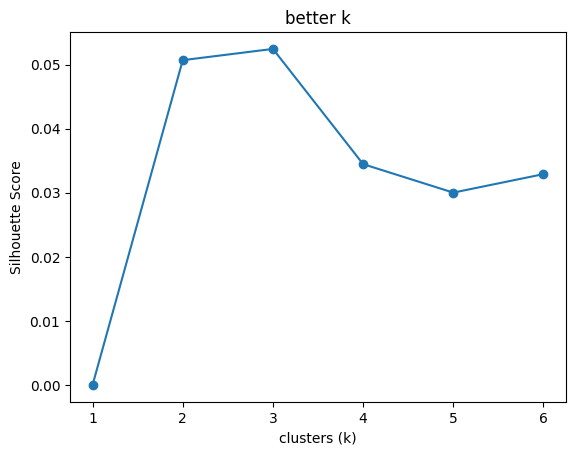

Silhouette scores: [0, np.float32(0.050692648), np.float32(0.05244712), np.float32(0.034463372), np.float32(0.030018803), np.float32(0.032903593)]


In [44]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

# warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# embedding into matrix
X = np.vstack(df_news['EMBEDDINGS'].values)
mask = np.all(np.isfinite(X), axis=1)
X = X[mask]
df_news_clean = df_news.iloc[mask].reset_index(drop=True)

#  silhouette scores
sil_scores = []
for k in range(1, 7):
    if k == 1:
        sil_scores.append(0)
        continue
    if len(X) < k:
        sil_scores.append(0)
        continue
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    sil_scores.append(score)

# Graph
plt.plot(range(1, 7), sil_scores, marker='o')
plt.xlabel('clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('better k')
plt.show()

print("Silhouette scores:", sil_scores)


#### Identify the Best k

In [45]:
best_k = np.argmax(sil_scores)
print(f"Best numer of clusters (k): {best_k}")

Best numer of clusters (k): 2


#### Cluster the embeddings using 3 clusters (k=3)

In [46]:
# cleaning
X = np.vstack(df_news['EMBEDDINGS'].values)
mask = np.all(np.isfinite(X), axis=1)
X = X[mask]
df_news_clean = df_news.iloc[mask].reset_index(drop=True)

#  KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

# add labbels
df_news_clean['CLUSTER'] = kmeans.labels_

# show results
df_news_clean[['TICKER', 'TITLE', 'CLUSTER']].head(10)


,TICKER,TITLE,CLUSTER
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,2
1,AOS,Here's Why A.O. Smith (AOS) is a Strong Value ...,0
2,ABT,Revvity trims 2025 profit forecast as China po...,2
3,ABBV,HS market forecast to reach $7.8bn across 7MM ...,2
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,0
5,ADBE,"Tech, Media & Telecom Roundup: Market Talk",2
6,AMD,"AMD stock jumps on 3 catalysts, Boeing faces p...",0
7,AES,AES to Report Q2 Earnings: What's in Store for...,1
8,AFL,Can ACGL's New Health Suite Boost Growth and E...,2
9,A,Agilent Technologies' Q3 2025 Earnings: What t...,1


### Visualize the 2 first PCA Components of your embeddings

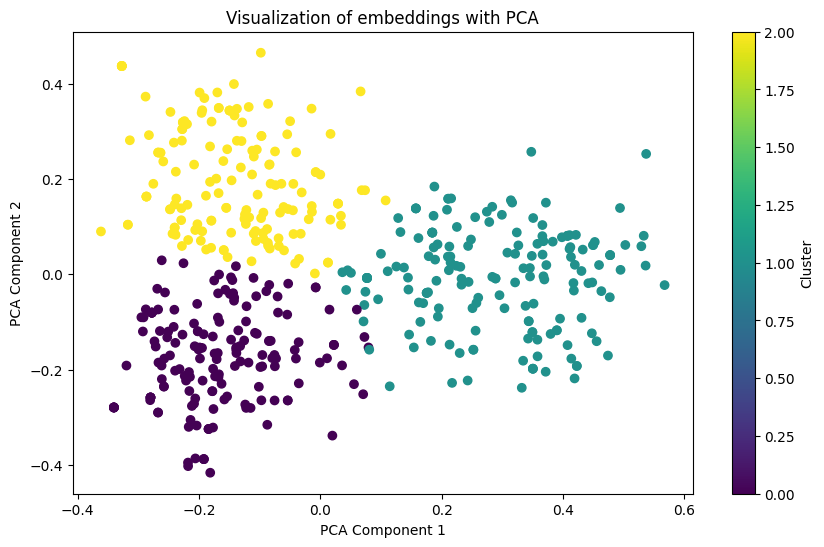

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=df_news_clean['CLUSTER'], cmap='viridis')
plt.title('Visualization of embeddings with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [ ]:
for cluster_id in sorted(df_news_clean['CLUSTER'].unique()):
    print(f"\n🔹 Cluster {cluster_id} - News:")
    cluster_news = df_news_clean[df_news_clean['CLUSTER'] == cluster_id]
    print(cluster_news[['TICKER', 'TITLE']].head(5))


🔹 Cluster 0 - News:
   TICKER                                              TITLE
1     AOS  Here's Why A.O. Smith (AOS) is a Strong Value ...
4     ACN  Accenture’s (ACN) Oversold Status May Offer a ...
6     AMD  AMD stock jumps on 3 catalysts, Boeing faces p...
12   AKAM  Akamai Technologies (AKAM) Stock Declines Whil...
13    ALB  S&P 500 Gains & Losses Today: Supermicro, Nike...

🔹 Cluster 1 - News:
   TICKER                                              TITLE
7     AES  AES to Report Q2 Earnings: What's in Store for...
9       A  Agilent Technologies' Q3 2025 Earnings: What t...
16   ALLE  Allegion Second Quarter 2025 Earnings: Beats E...
17    LNT  Alliant Energy’s Quarterly Earnings Preview: W...
18    ALL  Palomar (PLMR) Earnings Expected to Grow: Shou...

🔹 Cluster 2 - News:
  TICKER                                              TITLE
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...
2    ABT  Revvity trims 2025 profit forecast as China po...
3   ABBV  HS market forec



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

MiniLM is faster and lighter but may fail in longer texts, so its better to use a larger model for higher accuracy if resources allow; MiniLM is suitable for efficiency and speed.
---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

	•	TITLE: Captures the main idea of the news, but could be confusing if its a clicbait.
	•	SUMMARY: Provides additional context, gets more comprehensive embeddings.
	•	Combination: Improves semantic representation.
	•	How to test: Generate embeddings for each one of the options, perform clustering, and compare silhouette scores for example.
---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

	•	PCA: Linear method, fast, and good for initial dimensionality reduction.
	•	UMAP: Non-linear methods that capture complex structures, this would make more detailed cluster visualization.

---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

	•	News from different topics may mix due to shared vocabulary, 
	•	Some clusters have very few data points, making interpretation unreliable.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

	•	Some isolated points may appear if we made alonger EDA, but not at this point.
	•	Detection: Measure distance to cluster centroid por example if we dont need a complex EDA.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

News, Reports and Speculations. In this case, i will be searching for time words, from the past or "posible future".



---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

Adding sentiment scores could separate clusters, so it could improve interpretability for financial analysis by differentiating market reactions.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

ssumes spherical, balanced clusters. Also is sensitive to outliers. i would use DBSCAN (handles outliers automatically)

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

using High-level pipeline, or some automator, like Jenkins, I think that news are the text versions of moving averages, so a model to analize 
info from news should be fresh every single day.

---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

News content may not strongly correlate with price changes, also those are semantic similarity models, not necessarily predictive models.
